
# Nightly PulseShift Crowd Energy Demo

This notebook analyzes a 30–60 second crowd video, suggests show cues for low-energy moments, and exports a 10-second highlight clip from the highest-energy window.

**Steps to use:**
1. Run the install cell.
2. Upload your video file when prompted.
3. Run all cells.


In [ ]:

# Install dependencies
!pip -q install opencv-python-headless librosa moviepy matplotlib numpy


In [22]:

import os, json, numpy as np, cv2, librosa
import matplotlib.pyplot as plt
import moviepy.editor as mp

def read_video_basic_info(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    return frame_count, fps, width, height

def compute_motion_energy(video_path, sample_fps=5.0, resize_w=320):
    frame_count, fps, w, h = read_video_basic_info(video_path)
    step = max(int(round(fps / sample_fps)), 1)
    cap = cv2.VideoCapture(video_path)
    prev = None
    energies, times = [], []
    idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx % step == 0:
            g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            scale = resize_w / g.shape[1]
            g = cv2.resize(g, (resize_w, int(g.shape[0]*scale)))
            g = cv2.GaussianBlur(g, (5,5), 0)
            if prev is not None:
                diff = cv2.absdiff(g, prev)
                energies.append(float(np.mean(diff)))
                times.append(idx / fps)
            prev = g
        idx += 1
    cap.release()
    return np.array(times, dtype=float), np.array(energies, dtype=float)

def compute_audio_energy(video_path: str, target_sr: int = 22050):
    """
    Returns times (s) and RMS energy sampled from the audio track.
    Uses a robust path: write audio to WAV, then load with librosa.
    If audio is missing, returns empty arrays.
    """
    import numpy as np, librosa, moviepy.editor as mp
    try:
        clip = mp.VideoFileClip(video_path)
        if clip.audio is None:
            clip.close()
            return np.array([]), np.array([])
        tmp_wav = "tmp_audio.wav"
        # Write audio to a temp WAV at a known sample rate
        clip.audio.write_audiofile(tmp_wav, fps=target_sr, verbose=False, logger=None)
        clip.close()

        y, sr = librosa.load(tmp_wav, sr=target_sr, mono=True)
        if y.size == 0:
            return np.array([]), np.array([])

        frame_length = sr          # 1 second window
        hop_length = sr // 2       # 0.5 second hop
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length)
        return times, rms
    except Exception as e:
        print(f"[WARN] Audio energy skipped due to error: {e}")
        return np.array([]), np.array([])

def resample_to_seconds(times, values, duration_s):
    if len(values) == 0:
        return np.zeros(int(np.ceil(duration_s))+1)
    sec_bins = int(np.ceil(duration_s)) + 1
    out = np.zeros(sec_bins, dtype=float)
    counts = np.zeros(sec_bins, dtype=float)
    for t, v in zip(times, values):
        s = int(np.clip(np.floor(t), 0, sec_bins-1))
        out[s] += v
        counts[s] += 1.0
    counts[counts==0] = 1.0
    out = out / counts
    return out

def smooth(x, k=5):
    if k <= 1:
        return x
    k = min(k, len(x) - (1 - (len(x)>0)))
    if k <= 1:
        return x
    kernel = np.ones(k) / k
    return np.convolve(x, kernel, mode='same')

def normalize_zero_one(x):
    if len(x) == 0:
        return x
    lo, hi = float(np.min(x)), float(np.max(x))
    if hi <= lo + 1e-9:
        return np.zeros_like(x)
    return (x - lo) / (hi - lo)

def find_low_energy_moments(energy, q=0.35, min_gap_s=5):
    threshold = np.quantile(energy, q)
    idxs = [i for i, v in enumerate(energy) if v <= threshold]
    moments, last = [], -1e9
    for i in idxs:
        if i - last >= min_gap_s:
            moments.append(i)
            last = i
    return moments

def sliding_window_argmax(x, window_s=10):
    if len(x) <= window_s:
        return 0
    ps = np.concatenate([[0.0], np.cumsum(x)])
    best_sum, best_start = -1.0, 0
    for start in range(0, len(x) - window_s + 1):
        s = ps[start + window_s] - ps[start]
        if s > best_sum:
            best_sum, best_start = s, start
    return best_start

def cue_for_moment(moment_s):
    options = [
        "Scoreboard prompt: MAKE SOME NOISE",
        "Chant start: OLE OLE OLE",
        "Ribbon-board ripple in team colors",
        "Clap pattern on PA: clap-clap-clap",
        "Wave cue: sections light up front-to-back",
        "Fan-cam on diehards + lower-bowl lights up",
        "Stadium beat build, then whoosh SFX",
        "Spotlight sweep across stands",
        "Drumline hit on 1 and 3 for 8 bars",
        "Call and response: LEFT SIDE vs RIGHT SIDE"
    ]
    return options[moment_s % len(options)]



In [23]:
# Enter your video path manually
from pathlib import Path

video_path = input("Enter the full path to your 30-60s crowd video (you can get the path for you mp4 file by right clicking on it and copying path): ").strip()

if not video_path:
    raise ValueError("No path provided. Please enter a valid file path.")

p = Path(video_path).expanduser()
if not p.exists():
    raise FileNotFoundError(f"File not found: {p}")

video_path = str(p)
print("Using video:", video_path)


Enter the full path to your 30-60s crowd video (e.g., /content/clip.mp4): /content/Download.mp4
Using video: /content/Download.mp4


In [24]:
# Sports profile knobs
MOTION_SAMPLE_FPS = 4.0
RESIZE_W = 320
AUDIO_WEIGHT = 0.6   # put more weight on crowd audio
SMOOTH_K = 5
LOW_Q = 0.40

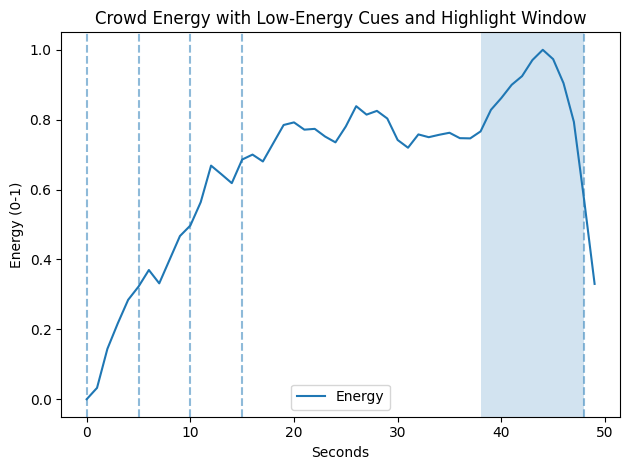

Low-energy cues: [{'second': 0, 'cue': 'Scoreboard prompt: MAKE SOME NOISE'}, {'second': 5, 'cue': 'Fan-cam on diehards + lower-bowl lights up'}, {'second': 10, 'cue': 'Scoreboard prompt: MAKE SOME NOISE'}, {'second': 15, 'cue': 'Fan-cam on diehards + lower-bowl lights up'}, {'second': 48, 'cue': 'Drumline hit on 1 and 3 for 8 bars'}]
Highlight start (s): 38


In [25]:

# Analyze
clip = mp.VideoFileClip(video_path)
duration_s = int(np.ceil(clip.duration))
clip.close()

mt, me = compute_motion_energy(video_path, sample_fps=MOTION_SAMPLE_FPS, resize_w=RESIZE_W)
m_sec = resample_to_seconds(mt, me, duration_s)
m_sec = normalize_zero_one(m_sec)

at, ae = compute_audio_energy(video_path, target_sr=22050)
a_sec = resample_to_seconds(at, ae, duration_s)
a_sec = normalize_zero_one(a_sec)
AUDIO_WEIGHT = 0.6  # sports crowd: lean on audio

if np.all(a_sec == 0.0):
    w_m, w_a = 1.0, 0.0
else:
    w_m, w_a = 1.0 - AUDIO_WEIGHT, AUDIO_WEIGHT
energy = w_m * m_sec + w_a * a_sec
energy = smooth(energy, k=SMOOTH_K)
energy = normalize_zero_one(energy)

# find moments
lows = find_low_energy_moments(energy, q=LOW_Q, min_gap_s=5)
highlight_start = sliding_window_argmax(energy, window_s=10)

# cues
cues = [{"second": int(s), "cue": cue_for_moment(int(s))} for s in lows]

# save artifacts
os.makedirs("outputs", exist_ok=True)

# energy CSV
import csv
with open("outputs/energy.csv", "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["second", "energy_0to1"])
    for i, v in enumerate(energy):
        w.writerow([i, float(v)])

with open("outputs/cues.json", "w") as f:
    json.dump({"cues": cues}, f, indent=2)

# plot
plt.figure()
x = np.arange(len(energy))
plt.plot(x, energy, label="Energy")
for s in lows:
    plt.axvline(s, linestyle="--", alpha=0.5)
hs = highlight_start
he = min(hs + 10, len(energy)-1)
plt.axvspan(hs, he, alpha=0.2)
plt.xlabel("Seconds")
plt.ylabel("Energy (0-1)")
plt.title("Crowd Energy with Low-Energy Cues and Highlight Window")
plt.legend()
plt.tight_layout()
plt.savefig("outputs/energy_plot.png", dpi=160)
plt.show()

print("Low-energy cues:", cues)
print("Highlight start (s):", highlight_start)


In [26]:

# Export 10-second highlight clip
hs = int(highlight_start)
full = mp.VideoFileClip(video_path)
end_s = min(hs + 10, int(np.floor(full.duration)))
clip = full.subclip(hs, end_s)
out_path = "outputs/highlight_clip.mp4"
clip.write_videofile(out_path, codec="libx264", audio_codec="aac")
full.close()
clip.close()
out_path


Moviepy - Building video outputs/highlight_clip.mp4.
MoviePy - Writing audio in highlight_clipTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video outputs/highlight_clip.mp4



Moviepy - Done !
Moviepy - video ready outputs/highlight_clip.mp4


'outputs/highlight_clip.mp4'